In [41]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import scipy.optimize as spo
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnpl
from jax.config import config
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [2]:
# size of spatial domain
L = 10.0
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

---
**Potential Function**

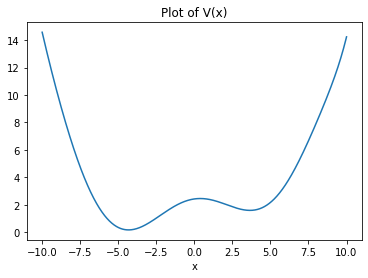

In [15]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    # return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    c8 = 4.12e-7; c9 = 1.65e-8
    x = z + 0.8
    return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 \
           + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

---
**Initial Wave Functions**

Vector L2 Error psi0_0: 4.072507283504947e-06
Vector L-infinity Error psi0_0: 1.8301527573169486e-06
Vector L2 Error psi0_1: 4.072507283501257e-06
Vector L-infinity Error psi0_1: 1.8301527573114097e-06


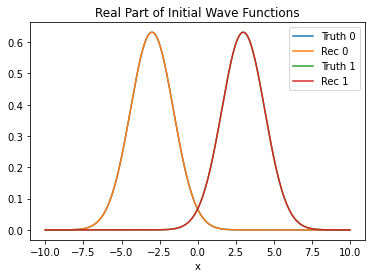

In [16]:
# define initial states and transform to Fourier basis

def psi0_1(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

# compute psi0 normalization term
psi0_1_prob_intgrnd = lambda x: np.abs(psi0_1(x)) ** 2
psi0_1_norm = np.sqrt(si.quad(psi0_1_prob_intgrnd, -L, L)[0])

# normalized psi function (for integration)
norm_psi0_1_fn = lambda x: psi0_1(x) / psi0_1_norm

# compute the Fourier representation of psi0_1
norm_psi0_1 = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return norm_psi0_1_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) \
               / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    norm_psi0_1.append(si.quad(rintgrnd, -L, L)[0] \
                       + 1j * si.quad(iintgrnd, -L, L)[0])

a0_1 = np.concatenate([np.conjugate(np.flipud(norm_psi0_1[1:])), norm_psi0_1])


def psi0_2(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

# compute psi0 normalization term
psi0_2_prob_intgrnd = lambda x: np.abs(psi0_2(x)) ** 2
psi0_2_norm = np.sqrt(si.quad(psi0_2_prob_intgrnd, -L, L)[0])

# normalized psi function (for integration)
norm_psi0_2_fn = lambda x: psi0_2(x) / psi0_2_norm

# compute the Fourier representation of psi0_1
norm_psi0_2 = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return norm_psi0_2_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) \
               / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    norm_psi0_2.append(si.quad(rintgrnd, -L, L)[0] \
                       + 1j * si.quad(iintgrnd, -L, L)[0])

a0_2 = np.concatenate([np.conjugate(np.flipud(norm_psi0_2[1:])), norm_psi0_2])

a0vec = []
a0vec.append(a0_1)
a0vec.append(a0_2)


# check if Fourier representation is close to truth

normpsi0xvec = []
normpsi0xvec.append(norm_psi0_1_fn(xvec))
normpsi0xvec.append(norm_psi0_2_fn(xvec))

normpsi0recxvec = []
for thisa0 in a0vec:
    normpsi0recxvec.append(thisa0 @ fourtox)

# plot the real part of the normalized psi0
for i in range(len(normpsi0xvec)):
    print(f'Vector L2 Error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'Vector L-infinity Error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    plt.plot(xvec, normpsi0xvec[i].real, label=f"Truth {i}")
    plt.plot(xvec, normpsi0recxvec[i].real, label=f"Rec {i}")

plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

---
<h3>Foward Propagation</h3>

In [17]:
# transform potential to Fourier representation

# in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that the
# quadrature method produces much more accurate results than FFT
fourvtoep = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    fourvtoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
vmattrue = sl.toeplitz(r=fourvtoep, c=np.conj(fourvtoep))

print('Shape vmattrue:', vmattrue.shape)

# print('L2 Error of Potential in Fourier Representation (shold be close to 0):', nl.norm(vmattrue @ fourtox - vxvec), sep='\n')
#
# print(len(fourvtoep))
# print(vmattrue.shape)
#
# plt.plot(xvec, vxvec, label='Truth')
# plt.plot(xvec, fourvtoep @ vmattrue, label='Rec')
# plt.title('True Potential vs. Fourier Representation')
# plt.legend()
# plt.show()

Shape vmattrue: (65, 65)


---
**Eigendecomposition of a Fourier Represented Potential**

In [18]:
# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = nl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
2.6022021582759417e-13
stttrue unitary check (should be close to zero):
1.1796799856311874e-14


---

[0.58347051 1.36721985 1.93287887 2.0619398  2.47662914 2.68184405]


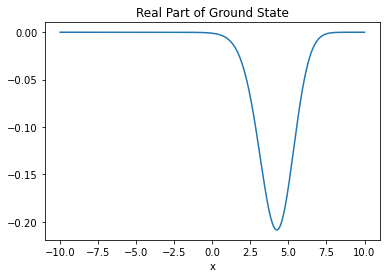

Quick normalization check (should be close to 1):
1.0000000000000004
Accurate normalization check (should be close to 1):
1.0000000000000002


In [19]:
# find indices that sort eigenvalues
ordering = np.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
**Propagate**

In [20]:
# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 100  # 200


# compute propagator matrix
propatrue = stttrue @ np.diag(np.exp(-1j * spctrue * dt)) @ stttrue.conj().T

amattrue = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for i in range(numts):
        tempamat.append(propatrue @ tempamat[-1])
    amattrue.append(tempamat)

amattrue = np.array(amattrue)

print('Done propagating')

Done propagating


In [21]:
# check system's state is normalized to 1 for each
# time step

psimatvec = amattrue @ fourtox
print('Shape psimatvec:', psimatvec.shape)
print('psimatvec.shape[2]:', psimatvec.shape[2])

normpsimatvec = si.trapezoid(np.abs(psimatvec)**2, xvec, axis=2)
print('Shape normpsimatvec:', normpsimatvec.shape)

Shape psimatvec: (2, 101, 1025)
psimatvec.shape[2]: 1025
Shape normpsimatvec: (2, 101)


Average Norm of Trajectory 0 (should be close to 1):
0.999999999999584
Average Norm of Trajectory 1 (should be close to 1):
0.9999999999996184


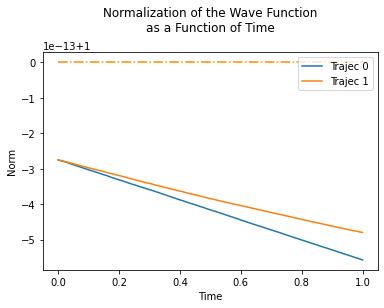

In [22]:
# plot normalization (should be almost flat line at 1)

for i in range(normpsimatvec.shape[0]):
    print(f'Average Norm of Trajectory {i} (should be close to 1):', normpsimatvec[i].sum() / (numts + 1), sep='\n')
    plt.plot(np.arange(numts + 1) * dt, normpsimatvec[i], label=f'Trajec {i}')

plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()


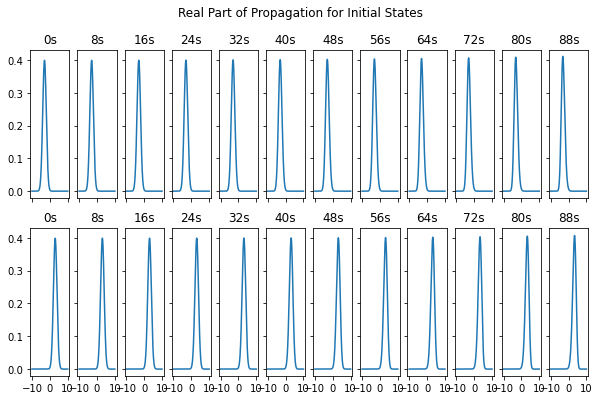

In [23]:
# look at propagation results for anything that may cause
# issues as learning data

numsnapshots = 12

fig, axs = plt.subplots(nrows=len(a0vec), ncols=numsnapshots, sharex='all', sharey='all', figsize=(10, 6))

plottstep = numts // numsnapshots

for i in range(2):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs((amattrue[i] @ fourtox)[plottstep * j]) ** 2)
        axs[i, j].set_title(f'{plottstep * j}s')


fig.suptitle('Real Part of Propagation for Initial States')

plt.show()

---
<h3>Chebyshev Representation</h3>

In [24]:
# set the number of Chebyshev coefficients
# from experience, odd values work best
numcheb = 11  # 31

def theta(k):
    return (k - 0.5) * np.pi / (numcheb + 1)

def g(k):
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, numcheb + 2)
chebnvec = np.arange(0, numcheb + 1)

chebweights = np.ones(numcheb + 1)
chebweights[0] = 0.5

chebtox = sps.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / L, 1))

[ 6.30089288e+00  5.19674852e-01  6.64573526e+00 -6.96001014e-01
  1.90705582e+00 -1.25458680e-01 -6.58677000e-01  1.01520313e-01
  2.07343750e-01  3.22265625e-02 -1.28045722e-14  3.88578059e-15]


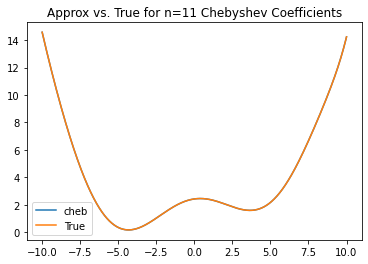

Reconstruction L2 Error (should be close to zero):
3.4519210698760405e-13
Reconstruction L-infinity Error (should be close to zero):
5.1514348342607263e-14


In [25]:
# compute Chebyshev coefficients for true potential
cfftrue = 2 / (numcheb + 1) * np.sum(g(kvec) * np.cos(chebnvec[..., np.newaxis] * theta(kvec)), axis=1)
cfftrue = chebweights * cfftrue
print(cfftrue)

# plot reconstruction vs truth
plt.plot(xvec, chebtox @ cfftrue, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={numcheb} Chebyshev Coefficients')
plt.legend()
plt.show()

# vec L2 error
print('Reconstruction L2 Error (should be close to zero):', nl.norm(v(xvec) - chebtox @ cfftrue), sep='\n')
# L-infinity error
print('Reconstruction L-infinity Error (should be close to zero):', np.max(np.abs(v(xvec) - chebtox @ cfftrue)), sep='\n')

---
**Propagation using Chebyshev Representation**

Shape chebtofour: (65, 65, 12)
L2 Error of vmat (should be close to 0):
3.7104515434340983e-13
L-infinity Error of vmat (should be close to 0):
4.194175224892439e-14


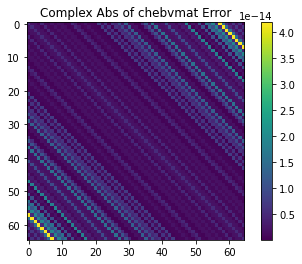

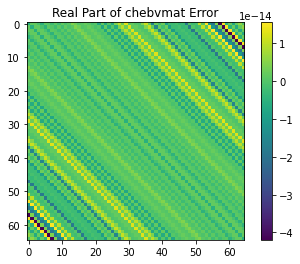

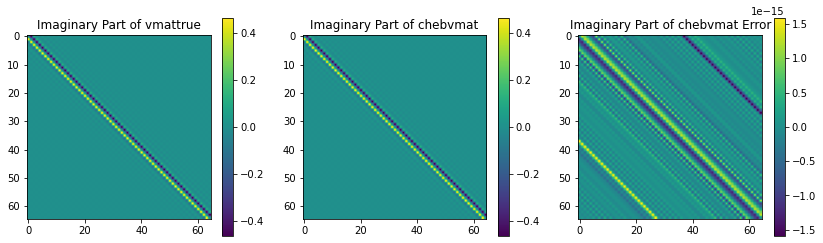

In [59]:
# matrix to transform cheb to four
chebtofour = []
for thischebn in range(numcheb + 1):
    temptoeprow = []
    for thisfourn in range(2 * numfour + 1):
        def intgrnd(x):
            return sps.eval_chebyt(thischebn, x / L) \
                   * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
    chebtofour.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

chebtofour = np.array(chebtofour).T
print('Shape chebtofour:', chebtofour.shape)

chebvmat = np.flip(chebtofour @ cfftrue)

# check if potential in Fourier representation
# constructed from Chebyshev coefficients close to
# true Fourier coefficients
print('L2 Error of vmat (should be close to 0):', nl.norm(vmattrue - chebvmat), sep='\n')
print('L-infinity Error of vmat (should be close to 0):', np.max(np.abs(vmattrue - chebvmat)), sep='\n')

plt.imshow(np.abs(vmattrue - chebvmat))
plt.colorbar()
plt.title('Complex Abs of chebvmat Error')
plt.show()

plt.imshow(np.real(vmattrue - chebvmat))
plt.colorbar()
plt.title('Real Part of chebvmat Error')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

im0 = axs[0].imshow(np.imag(vmattrue))
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('Imaginary Part of vmattrue')

im1 = axs[1].imshow(np.imag(chebvmat))
fig.colorbar(im1, ax=axs[1])
axs[1].set_title('Imaginary Part of chebvmat')

im2 = axs[2].imshow(np.imag(vmattrue - chebvmat))
fig.colorbar(im2, ax=axs[2])
axs[2].set_title('Imaginary Part of chebvmat Error')

plt.show()

---
**Eigendecomposition of a Chebyshev Represented Potential**

In [244]:
# to test our Chebyshev representation let's compare
# the Hamiltonian matrix and its eigendecomposition
# constructed from the potential matrix reconstructed
# from the Chebyshev coefficients of the potential
# to the same features constructed directly in the
# Fourier representation

# make the potential matrix from the Chebyshev coefficents
# cvmat = sl.toeplitz(r=chebtofour @ cvec, c=np.conj(chebtofour @ cvec))
cvmat = chebtofour @ cfftrue

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

# results for the original way
# hmat Hermitian check (should be close to zero):
# 0.0
# Check if hmat is diagonalized (should be close to zero):
# 3.264297626570781e-13
# Unitary stts check (should be close to zero):
# 1.1878611598105484e-14

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
2.136147670802644e-13
Unitary stts check (should be close to zero):
1.2283652293521849e-14


In [245]:
print('L2 Error of the Hamiltonian matrix (should be close to 0):', nl.norm(cvmat - vmattrue), sep='\n')
print('L2 Error of spectrum (should be close to 0):', nl.norm(cspc - spctrue), sep='\n')
print('L2 Error of states (should be close to 0):', nl.norm(cstts - stttrue), sep='\n')

# results for the original way
# L2 Error of the Hamiltonian matrix (should be close to 0):
# 1.44838302671362e-12
# L2 Error of spectrum (should be close to 0):
# 5.43553446497394e-13
# L2 Error of states (should be close to 0):
# 7.48331477354788

L2 Error of the Hamiltonian matrix (should be close to 0):
5.665383265681855
L2 Error of spectrum (should be close to 0):
3.0693095958842102e-06
L2 Error of states (should be close to 0):
11.258725816170891


---
**Forward Propagation of ainit using the Potential in the Cheybshev Representation**

In [246]:
# propagate the system using the Chebyshev
# representation of the true potential and compare
# if chebyshev propagation agrees with Fourier
# propagation

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
# cspc, cstts
cpropa = cstts @ np.diag(np.exp(-1j * cspc * dt)) @ cstts.conj().T

camatvec = []
# propagate the system starting from the initial "a" state
for thisa0 in a0vec:
    tempcamat = np.zeros((numts + 1, 2 * numfour + 1), dtype=np.complex128)
    tempcamat[0] = thisa0.copy()
    for i in range(numts):
        tempcamat[i + 1] = cpropa @ tempcamat[i]
    camatvec.append(tempcamat)

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
cpsimat_1 = camatvec[0] @ fourtox
cpsimat_2 = camatvec[1] @ fourtox

print('Done propagating.')

Done propagating.


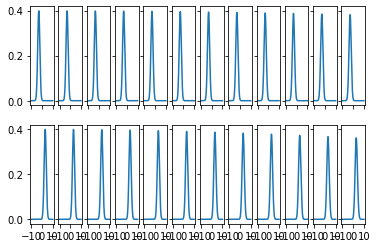

In [247]:
fig, axs = plt.subplots(nrows=2, ncols=numsnapshots, sharex='all', sharey='all')

plottstep = numts // numsnapshots

for i in range(2):
    for j in range(numsnapshots):
        axs[i, j].plot(xvec, np.abs((camatvec[i] @ fourtox)[plottstep * j]) ** 2)

plt.show()

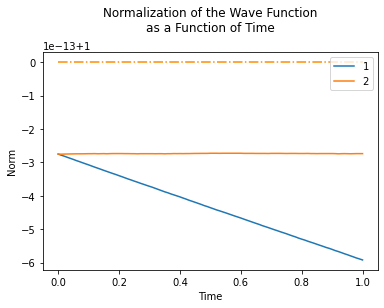

Average Norm of Trajectory 1 (should be close to 1):
0.9999999999995652
Average Norm of Trajectory 2 (should be close to 1):
0.9999999999997267


In [248]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
cpsimatnormvec_1 = si.trapezoid(np.abs(cpsimat_1) ** 2, xvec, axis=1)
plt.plot(np.arange(numts + 1) * dt, cpsimatnormvec_1, label='1')
cpsimatnormvec_2 = si.trapezoid(np.abs(cpsimat_2) ** 2, xvec, axis=1)
plt.plot(np.arange(numts + 1) * dt, cpsimatnormvec_2, label='2')
plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory 1 (should be close to 1):', cpsimatnormvec_1.sum() / (numts + 1), sep='\n')
print('Average Norm of Trajectory 2 (should be close to 1):', cpsimatnormvec_2.sum() / (numts + 1), sep='\n')

L2 Error Trajectory 1 (should be close to 0):
38.19667675323399
L-infinity Error Trajectory 1 (should be close to 0):
0.5811061283492793
L2 Error Trajectory 2 (should be close to 0):
38.19634207723405
L-infinity Error Trajectory 2 (should be close to 0):
0.5810985552175582


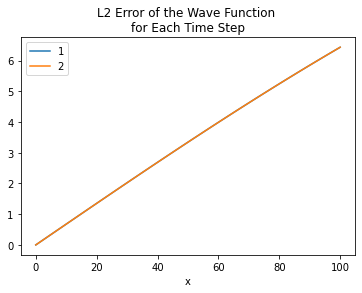

In [249]:
print('L2 Error Trajectory 1 (should be close to 0):', nl.norm(cpsimat_1 - Fpsimat_1), sep='\n')
print('L-infinity Error Trajectory 1 (should be close to 0):', np.max(np.abs(cpsimat_1 - Fpsimat_1)), sep='\n')
print('L2 Error Trajectory 2 (should be close to 0):', nl.norm(cpsimat_2 - Fpsimat_2), sep='\n')
print('L-infinity Error Trajectory 2 (should be close to 0):', np.max(np.abs(cpsimat_2 - Fpsimat_2)), sep='\n')

plt.plot(nl.norm(cpsimat_1 - Fpsimat_1, axis=1), label='1')
plt.plot(nl.norm(cpsimat_2 - Fpsimat_2, axis=1), label='2')
plt.title('L2 Error of the Wave Function \nfor Each Time Step')
plt.xlabel('x')
plt.legend()
plt.show()

---
<h3>Inverse Problem - Adjoint Method</h3>

In [250]:
# this code is used to make a toeplitz matrix from the
# Fourier representation
# flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numfour + 1
a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
toepindxmat = jnp.array(a + b)
print(toepindxmat.shape)

(65, 65)


In [251]:
# convert python list to JAX object
jaxFamatvec = jnp.stack(amattrue)
print(jaxFamatvec.shape)

# convert the NumPy chebtofour matrix to a JAX object
jaxchebtoF = jnp.array(chebtofour)
print(jaxchebtoF.shape)

(2, 101, 65)
(65, 65, 12)


In [252]:
def cobjfn(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    # cvrow = jaxchebtoF @ cffs
    # flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # vhatmat = jnp.array(flattoepvec[toepindxmat])
    vhatmat = jaxchebtoF @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnpl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    ahatmatvec = []
    # propagate the system starting from the initial "a" state
    for thisainit in a0vec:
        tempamat = [thisainit.copy()]
        for i in range(numts):
            tempamat.append(propahatmat @ tempamat[i])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))
    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)

    # compute the sum of objective functions in one line
    residue = ahatmatvec - jaxFamatvec
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

In [253]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
print('Objective for True Chebyshev Coefficients (should be close to 0):', cobjfn(cfftrue), sep='\n')

Objective for True Chebyshev Coefficients (should be close to 0):
28.49557288137052


In [254]:
jitcobjfn = jax.jit(cobjfn)

In [255]:
jitcobjfn(cfftrue)

DeviceArray(28.49557288, dtype=float64)

In [256]:
jaxgradcobjfn = jax.jit(jax.grad(cobjfn))

In [257]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
print('jaxgradcobjfn(cvec) (should be close to 0):', jaxgradcobjfn(cfftrue), sep='\n')

jaxgradcobjfn(cvec) (should be close to 0):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]


---
**Initialize with true coefficients perturbed by random normally distributed noise**

In [258]:
# easy test case: initialize theta with true theta perturbed with
# random normally distributed noise with a small variance.
# This should be easy for the optimizer to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cfftrue.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfftrue.shape)
# cfftrub += 5.0 * np.random.default_rng(seed).normal(size=cvec.shape)

In [259]:
# print(cobjfn(cfftrub))
# print(gradcobjfn(cfftrub))

In [260]:
restrubjaxgrad = spo.minimize(jitcobjfn, cfftrub, jac=jaxgradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 103
         Function evaluations: 176
         Gradient evaluations: 164


In [261]:
def sqrerrorfn(x, cffs):
    return (sps.eval_chebyt(chebnvec, x / L) @ cffs - v(x)) ** 2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cfftrue)))[0], sep='\n')

Continuous L2 Error of Potential using Quadrature Method:
3.406051033103937e-05


Objective of the Learned Coefficients:
2.2011845813319967e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
2.7729704086487705e-12
Continuous L2 Error of Potential using Quadrature Method:
3.199046805851998


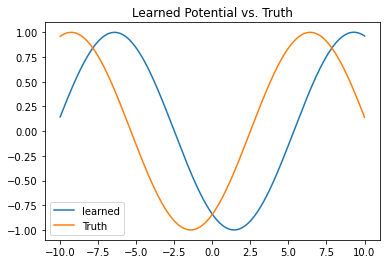

In [262]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', restrub, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(restrubjaxgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubjaxgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubjaxgrad)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(restrub), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cfftrub), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - restrub), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cfftrub)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - restrub)), sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cfftrub, label='initial')
plt.plot(xvec, chebtox @ restrubjaxgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [263]:
seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cfftrue.shape)

In [264]:
resform = spo.minimize(jitcobjfn, cffform, jac=jaxgradcobjfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x
# used 'maxiter': 200 and numcheb = 1 for harmonic potential and sin(x)

         Current function value: 0.000000
         Iterations: 121
         Function evaluations: 240
         Gradient evaluations: 226


Objective of the Learned Coefficients:
2.2011845334502423e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
4.691120100557708e-11
Continuous L2 Error of Potential using Quadrature Method:
3.1990468124257996


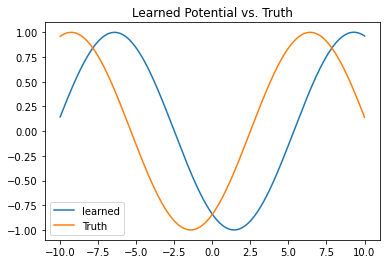

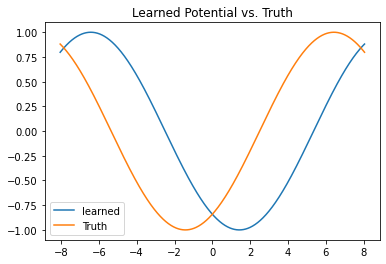

In [265]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(resform), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cffform), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - resform), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cffform)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - resform)), sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cffform, label='initial')
plt.plot(xvec, chebtox @ resform, label='learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

# plot learned vs true
plt.plot(xvec[100:-100], (chebtox @ resform)[100:-100], label='learned')
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [266]:
def adjhelper(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    # cvrow = jaxchebtoF @ cffs
    # flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # vhatmat = jnp.array(flattoepvec[toepindxmat])
    vhatmat = jaxchebtoF @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, sttshat = jnpl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = sttshat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ sttshat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    # compute backwards in time propagator of lmat
    # using the result of the eigendecomposition
    proplmat = sttshat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ sttshat.conj().T

    ahatmatvec = []
    lmatvec = []

    # propagate the system starting from the initial "a" state
    for i in range(len(amattrue)):
        tempamat = [a0vec[i].copy()]
        for j in range(numts):
            tempamat.append(propahatmat @ tempamat[j])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))

        # propagate the "lambda" vector of coefficients backward
        # in time, i.e., solve the adjoint problem
        templmat = [ahatmatvec[-1][numts, :] - amattrue[i][numts, :]]
        # itr = 0 # forward evaluation of lmat
        for j in range(numts - 1, 0 - 1, -1):
            templmat.append(ahatmatvec[-1][j,:] - amattrue[i][j] + proplmat @ templmat[numts - 1 - j])
            # templmat.append(thisahatmat[j,:] - amattrue[i][j] + proplmat @ templmat[itr] )
            # itr += 1
        # make python list a jax object
        lmatvec.append(jnp.flipud(jnp.stack(templmat)))

    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)
    # make python list a jax object
    lmatvec = jnp.stack(lmatvec)

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxchebtoF, sttshat) * jnp.expand_dims(mask, 2)
    # print('sttshat.conj().T.shape', sttshat.conj().T.shape)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    # ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    # ws = ws[1:, :]
    # ws = ws.T
    # ctrmats = ws[toepindxmat]
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    # derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, ctrmats, sttshat) * jnp.expand_dims(mask, 2)
    derivamats = jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, jaxchebtoF, sttshat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil', sttshat, derivamats, sttshat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # alldmat = (jnp.einsum('ij,jkm,kl->ilm', sttshat.conj().T, chebtofour, sttshat) * jnp.expand_dims(mask, 2)).T
    # print('Shape alldmat', alldmat.shape)

    return ahatmatvec, lmatvec, alldmat

def cgradfn(cffs):
    ahatmatvec, lmatvec, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('bij,ajk,bik->a', jnp.conj(lmatvec[:, 1:, :]), alldmat, ahatmatvec[:, :-1, :]).real[:numcheb + 1]
    return gradients

In [267]:
print('Shape cgradfn(cvec):', cgradfn(cfftrue).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(cfftrue), sep='\n')

print('Norm difference of JAX grads and adjoint grads (should be close to 0):', nl.norm(jaxgradcobjfn(cfftrue) - cgradfn(cfftrue)), sep='\n')

Shape cgradfn(cvec): (12,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]
Norm difference of JAX grads and adjoint grads (should be close to 0):
2.424748179101003e-12


In [268]:
jitcgradfn = jax.jit(cgradfn)

In [269]:
print('jitcgradfn(cvec):', jitcgradfn(cfftrue), sep='\n')
print('jaxgradcobjfn(cvec):', jaxgradcobjfn(cfftrue), sep='\n')

jitcgradfn(cvec):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]
jaxgradcobjfn(cvec):
[-2.20051169e-04  1.76827206e+01 -3.19512404e-02 -4.43192293e+01
  1.21376966e-01  5.02030801e+01 -2.33844896e-01 -3.55802369e+01
  2.98585345e-01  1.11530358e+01 -2.43945375e-01  9.97337219e+00]


In [270]:
# check if the JAX grads and adjoint grads are close

print('L2 Error of Grads (should be close to 0):', jnpl.norm(jaxgradcobjfn(cfftrue) - jitcgradfn(cfftrue)), sep='\n')
print('L-infinity Error of Grads (should be close to 0):', jnp.max(jnp.abs(jaxgradcobjfn(cfftrue) - jitcgradfn(cfftrue))), sep='\n')

L2 Error of Grads (should be close to 0):
2.4517456577153453e-12
L-infinity Error of Grads (should be close to 0):
1.5418777365994174e-12


---

In [271]:
restrubadjgrad = spo.minimize(jitcobjfn, cfftrub, jac=jitcgradfn, tol=1e-12, options={'maxiter': 400, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 103
         Function evaluations: 114
         Gradient evaluations: 112


Objective of the Learned Coefficients:
2.2011849934007433e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
1.2390754685702033e-12
Continuous L2 Error of Potential using Quadrature Method:
3.1990468072928127


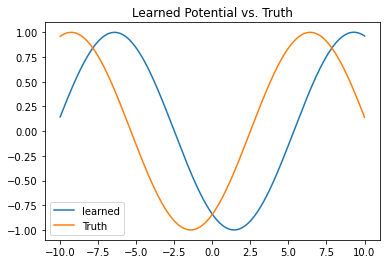

In [272]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', restrub, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(restrubadjgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubadjgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubadjgrad)))[0], sep='\n')

# plot learned vs true
plt.plot(xvec, chebtox @ restrubadjgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [273]:
resformadjgrad = spo.minimize(jitcobjfn, cffform, jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 122
         Function evaluations: 148
         Gradient evaluations: 142


Objective of the Learned Coefficients:
2.2011848584977247e-13
Vec L2 Norm of Gradient of the Learned Coefficients:
1.446328771776061e-12
Continuous L2 Error of Potential using Quadrature Method:
3.1990468073306637


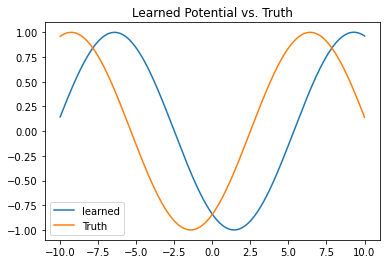

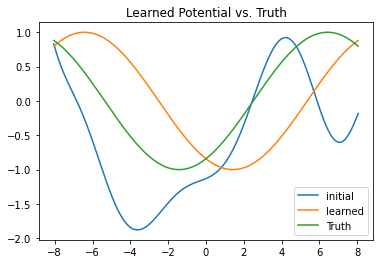

In [274]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(resformadjgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resformadjgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resformadjgrad)))[0], sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cfftrub, label='initial')
plt.plot(xvec, chebtox @ resformadjgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

# plot learned vs true
plt.plot(xvec[100:-100], (chebtox @ cfftrub)[100:-100], label='initial')
plt.plot(xvec[100:-100], (chebtox @ resformadjgrad)[100:-100], label='learned')
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()